# CoMPARA Predictions and Unrestricted Dataset Cross-Validation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem.MolStandardize import rdMolStandardize
import logging

from sklearn.metrics import precision_recall_curve

import ml
import utils
from analysis import CV, Predictions, violinplot_bayesian_estimate_of_performance_metrics

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
c:\Users\GNZFG\AppData\Local\miniforge-pypy3\envs\AndroR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

In [3]:
andror_df_pub = pd.read_csv("../AndroR_4_final_dataset_training_PUB_STD_rdkit.csv", index_col=0)

In [4]:
andror_df_all["unrestricted"] = andror_df_all["Compound No"].isin(andror_df_pub["Compound No"])

In [5]:
rdkit_descriptors = pd.read_csv("rdkit_descriptors.csv", index_col=0)

Need to remove one entry where at least one RDKit descriptor is missing

In [8]:
rdkit_descriptors = rdkit_descriptors.dropna()
andror_df_all = andror_df_all.loc[rdkit_descriptors.index]

In [6]:
andror_df_pub = andror_df_all[andror_df_all["unrestricted"]]
rdkit_descriptors_pub = rdkit_descriptors.loc[andror_df_all[andror_df_all["unrestricted"]].index]

# Train on Bayer HTS Data

In [9]:
HTS_model_unrestricted = ml.fit_model_or_retrieve_from_disc("pipelines_HTS_model_unrestricted.pkl", X=rdkit_descriptors_pub, y=andror_df_pub["final class"])
HTS_model_full = ml.fit_model_or_retrieve_from_disc("pipelines_HTS_model_full.pkl", X=rdkit_descriptors, y=andror_df_all["final class"])

# Predict CoMPARA

## Load and Prepare CoMPARA data

Generate RDKit descriptors for COMPARA Dataset

In [10]:
compara_dataset = pd.read_csv("../AR_binding_CoMPARA_raw_no_stereo_unique_SMILES.txt", sep="\t")

Find out how many entries are shared across our HTS dataset and CoMPARA

In [11]:
compara_dataset["SMILES_STD_FLAT"].isin(andror_df_all["flat_smiles"]).sum()

38

Remove all entries from CoMPARA Dataset which are already in our internal HTS set

In [12]:
compara_dataset = compara_dataset[~compara_dataset["SMILES_STD_FLAT"].isin(andror_df_all["flat_smiles"])]

In [13]:
rdkit_descriptors_compara = utils.get_rdkit_descriptors(compara_dataset, "SMILES_STD_FLAT")

Calculating RDKit descriptors: 100%|██████████| 1649/1649 [00:33<00:00, 48.70it/s]


There is one row where entries are missing:

In [14]:
missing_columns = rdkit_descriptors_compara.columns[rdkit_descriptors_compara.isnull().any()].tolist()
missing_columns

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [15]:
missing_rows = rdkit_descriptors_compara[rdkit_descriptors_compara.isnull().any(axis=1)]
len(missing_rows)

1

Just drop this single molecule

In [16]:
rdkit_descriptors_compara = rdkit_descriptors_compara.dropna()
compara_dataset = compara_dataset.loc[rdkit_descriptors_compara.index]

## Run Predictions for COMPARA

In [17]:
compara_predictions_trained_on_unrestricted = HTS_model_unrestricted.predict_proba(
    X=rdkit_descriptors_compara,
)

PREDICTIONS_compara_trained_on_unrestricted = Predictions(
    y=compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=compara_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    y_hat_proba=compara_predictions_trained_on_unrestricted,
)

CV_compara_trained_on_unrestricted = CV([{
    "y": compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": compara_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    "y_hat_proba": compara_predictions_trained_on_unrestricted,}
])

In [18]:
CV_compara_trained_on_unrestricted.folds[0].find_npv_halving_tnr()

{'NPV': 0.9435679611650485, 'TNR': 0.7872777017783857}

In [19]:
compara_predictions_trained_on_full = HTS_model_full.predict_proba(
    X=rdkit_descriptors_compara
)

PREDICTIONS_compara_trained_on_full = Predictions(
    y=compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=compara_predictions_trained_on_full[:, 1] > 0.5, 
    y_hat_proba=compara_predictions_trained_on_full,
)

CV_compara_trained_on_full = CV([{
    "y": compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": compara_predictions_trained_on_full[:, 1] > 0.5, 
    "y_hat_proba": compara_predictions_trained_on_full,}
])

In [20]:
CV_compara_trained_on_full.folds[0].find_npv_halving_tnr()

{'NPV': 0.9435679611650485, 'TNR': 0.7510259917920656}

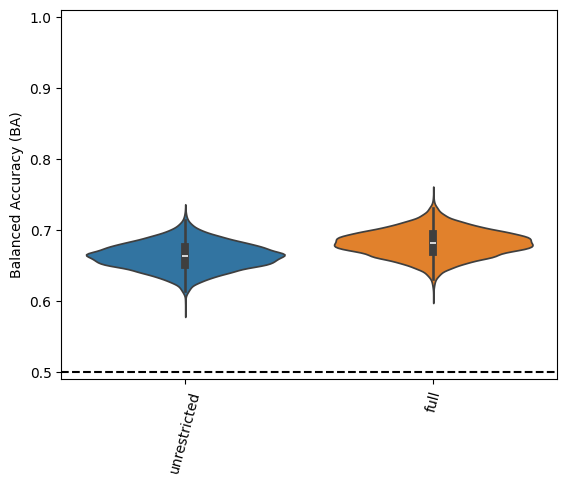

In [21]:
comparison_df_compara = violinplot_bayesian_estimate_of_performance_metrics({
    "unrestricted": CV_compara_trained_on_unrestricted,
    "full": CV_compara_trained_on_full,
})

In [22]:
comparison_df_compara.describe().loc[["mean", "std"]]

,unrestricted,full
mean,0.663774,0.681770
std,0.018682,0.018825


# Predictions for PubChem

## Load and Prepare PubChem data

In [ ]:
# SDF-Datei laden
sdf_file = "../Lunghini_data/EDdata_merged.sdf"
supplier = Chem.SDMolSupplier(sdf_file)

# Liste für DataFrame-Zeilen
data = []

for mol in supplier:
    if mol is not None:
        props = mol.GetPropsAsDict()
        props["SMILES"] = Chem.MolToSmiles(mol)
        data.append(props)

# DataFrame erstellen
df = pd.DataFrame(data)

In [ ]:
andror_df_pubchem = df[df["DB"] == "PubChem testset"]
andror_df_pubchem = andror_df_pubchem[andror_df_pubchem["Receptor"]=="AR"]
andror_df_pubchem = andror_df_pubchem[andror_df_pubchem["binding_prp"].notnull()]

andror_df_pubchem = andror_df_pubchem.rename(columns={"SMILES": "Structure"})

## Standardize and Flatten SMILES Strings

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('chemistry_standardization.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def standardize_smiles_rdkit(df):
    try:
        # Function to standardize a single SMILES using RDKit standardization
        def standardize_mol_rdkit(smiles):
            # Source: https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/MolStandardize/TransformCatalog/normalizations.in    
            RDLogger.DisableLog('rdApp.info')      
            smiles_std = None
            try:
                mol = Chem.MolFromSmiles(smiles)
                #print(mol.GetNumAtoms())
                if mol is not None:
                    Chem.SanitizeMol(mol,sanitizeOps=(Chem.SANITIZE_ALL^Chem.SANITIZE_CLEANUP^Chem.SANITIZE_PROPERTIES))
                    cm = rdMolStandardize.Normalize(mol)
                
                    uncharger = rdMolStandardize.Uncharger()
                    um = uncharger.uncharge(cm)
                
                    im = rdMolStandardize.Reionize(um)
                
                    lm = rdMolStandardize.FragmentParent(im)

                    #te = rdMolStandardize.TautomerEnumerator()  
                    #std_mol = te.Canonicalize(lm)
                    
                    # get smiles for standardized molecule
                    #smiles_std = Chem.MolToSmiles(std_mol, canonical=True)
                    smiles_std = Chem.MolToSmiles(lm, canonical=True)
                else:
                    smiles_std = 'remove'   
            finally:
                return smiles_std
        
        # Create new column with standardized SMILES
        df['std_smiles'] = df['Structure'].apply(standardize_mol_rdkit)
        
        # Print a few examples to verify
        print("\nFirst few standardized SMILES:")
        print(df[['Structure', 'std_smiles']].head())
        
        return df
    
        # Count successful conversions
        successful = df['std_smiles'].notna().sum()
        failed = df['std_smiles'].isna().sum()
        print(f"\nStandardization results:")
        print(f"Successfully standardized: {successful}")
        print(f"Failed to standardize: {failed}")
        
    except Exception as e:
        logger.error(f"Error during SMILES standardization: {e}")
        raise


def create_flat_smiles_rdkit(df):
    try:
        # Function to create flat SMILES using RDKit
        def flatten_single_smiles_rdkit(smiles):
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    # Remove stereochemistry
                    Chem.RemoveStereochemistry(mol)
                    # Convert to canonical SMILES
                    return Chem.MolToSmiles(mol, canonical=True)
                else:
                    return None
            except:
                return None
        
        # Create new column with flat SMILES
        df['flat_smiles'] = df['std_smiles'].apply(flatten_single_smiles_rdkit)
        
        # Print a few examples to verify
        print("\nFirst few flattened SMILES:")
        print(df[['Structure', 'std_smiles', 'flat_smiles']].head())
        
        return df
    except Exception as e:
        print(f"Error in flattening: {str(e)}")
        return df    
        
        # Count successful conversions
        successful = df['flat_smiles'].notna().sum()
        failed = df['flat_smiles'].isna().sum()
        print(f"\nFlattening results:")
        print(f"Successfully flattened: {successful}")
        print(f"Failed to flatten: {failed}")

    except Exception as e:
        logger.error(f"Error during SMILES flattening: {e}")
        raise

In [ ]:
andror_df_pubchem = standardize_smiles_rdkit(andror_df_pubchem)
andror_df_pubchem = create_flat_smiles_rdkit(andror_df_pubchem)

In [ ]:
common_entries = andror_df_pubchem[andror_df_pubchem['flat_smiles'].isin(andror_df_all['flat_smiles'])]

In [ ]:
common_entries

Drop entries that were in HTS data

In [ ]:
andror_df_pubchem = andror_df_pubchem[~andror_df_pubchem['flat_smiles'].isin(andror_df_all['flat_smiles'])]

In [24]:
# andror_df_pubchem.to_csv("../PubChem_AR.csv")
andror_df_pubchem = pd.read_csv("../PubChem_AR.csv", index_col=0)

In [ ]:
rdkit_descriptors_pubchem = utils.get_rdkit_descriptors(andror_df_pubchem)

Check if any rdkit features are identical

In [ ]:
deduplicated_merged_rdkit_features = pd.concat([rdkit_descriptors.drop_duplicates(), rdkit_descriptors_pubchem.drop_duplicates()])
print(deduplicated_merged_rdkit_features.shape)  # Ausgabe der Form des deduplizierten DataFrames
print(deduplicated_merged_rdkit_features.drop_duplicates().shape)  # Ausgabe der Form des deduplizierten DataFrames

There are no identical rdkit features in Pubchem compared to our HTS

In [25]:
# rdkit_descriptors_pubchem.to_csv("../rdkit_descriptors_pubchem.csv")
rdkit_descriptors_pubchem = pd.read_csv("../rdkit_descriptors_pubchem.csv", index_col=0)

Drop 12 compounds where rdkit features are not complete

In [26]:
rdkit_complete = rdkit_descriptors_pubchem.isna().sum(axis=1) == 0
rdkit_descriptors_pubchem = rdkit_descriptors_pubchem[rdkit_complete]
andror_df_pubchem = andror_df_pubchem[rdkit_complete]

There are 236 compounds where Ipc is > 1e10

In [27]:
rdkit_not_too_high = (rdkit_descriptors_pubchem > 1e10).sum(axis=1) == 0
rdkit_descriptors_pubchem = rdkit_descriptors_pubchem[rdkit_not_too_high]
andror_df_pubchem = andror_df_pubchem[rdkit_not_too_high]

## Run Predictions for PubChem

In [28]:
pubchem_predictions_trained_on_unrestricted = HTS_model_unrestricted.predict_proba(
    X=rdkit_descriptors_pubchem,
)

PREDICTIONS_pubchem_trained_on_unrestricted = Predictions(
    y=andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=pubchem_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    y_hat_proba=pubchem_predictions_trained_on_unrestricted,
    )

CV_pubchem_trained_on_unrestricted = CV([{
    "y": andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": pubchem_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    "y_hat_proba": pubchem_predictions_trained_on_unrestricted,}
])

In [29]:
CV_pubchem_trained_on_unrestricted.folds[0].find_npv_halving_tnr()

{'NPV': 0.8835050494746506, 'TNR': 0.8461231546748238}

In [30]:
pubchem_predictions_trained_on_full = HTS_model_full.predict_proba(
    X=rdkit_descriptors_pubchem
)

PREDICTIONS_pubchem_trained_on_full = Predictions(
    y=andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=pubchem_predictions_trained_on_full[:, 1] > 0.5, 
    y_hat_proba=pubchem_predictions_trained_on_full,
    )

CV_pubchem_trained_on_full = CV([{
    "y": andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": pubchem_predictions_trained_on_full[:, 1] > 0.5, 
    "y_hat_proba": pubchem_predictions_trained_on_full,}
])

In [31]:
CV_pubchem_trained_on_full.folds[0].find_npv_halving_tnr()

{'NPV': 0.8835050494746506, 'TNR': 0.769650219444075}

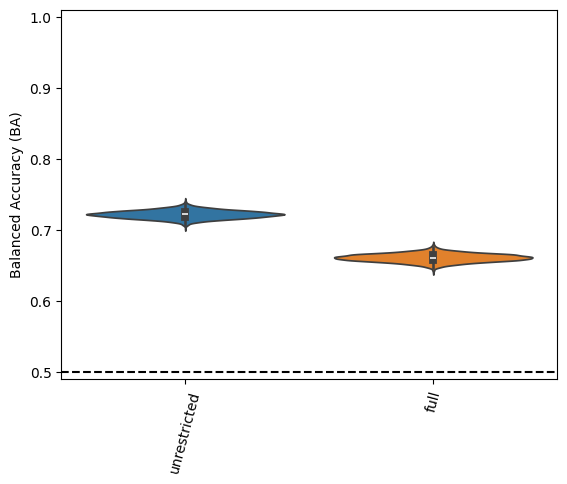

In [32]:
comparison_df_pubchem = violinplot_bayesian_estimate_of_performance_metrics({
    "unrestricted": CV_pubchem_trained_on_unrestricted,
    "full": CV_pubchem_trained_on_full,
})

In [33]:
comparison_df_pubchem.describe().loc[["mean", "std"]]

,unrestricted,full
mean,0.722056,0.661136
std,0.005551,0.005682


# Plot NPV-specifity curve for CoMPARA and PubChem for Manuscript

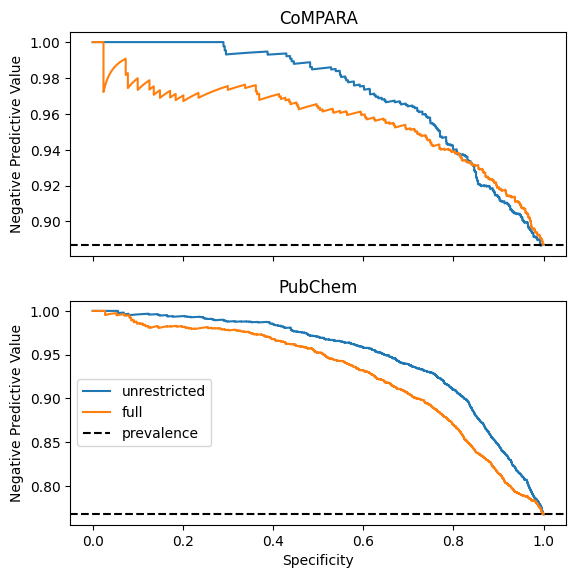

In [35]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6.4, 6.4))

curr_ax = axes[0]
curr_ax.set_title("CoMPARA")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_compara_trained_on_unrestricted.y, PREDICTIONS_compara_trained_on_unrestricted.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="unrestricted")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_compara_trained_on_full.y, PREDICTIONS_compara_trained_on_full.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="full")
curr_ax.axhline(1 - PREDICTIONS_compara_trained_on_full.prevalence, linestyle="--", c="k")
curr_ax.set_ylabel("Negative Predictive Value")

curr_ax = axes[1]
curr_ax.set_title("PubChem")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_pubchem_trained_on_unrestricted.y, PREDICTIONS_pubchem_trained_on_unrestricted.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="unrestricted")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_pubchem_trained_on_full.y, PREDICTIONS_pubchem_trained_on_full.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="full")
curr_ax.axhline(1 - PREDICTIONS_pubchem_trained_on_full.prevalence, linestyle="--", c="k")
curr_ax.set_ylabel("Negative Predictive Value")


plt.xlabel('Specificity')
plt.legend(["unrestricted", "full", "prevalence"])